# Toxic Comment Classification Challenge
## BERT - TensorFlow 2 & Hugging Face Transformers Library

In [2]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 
# good output must be => ['/device:CPU:0', '/device:GPU:0']

['/device:CPU:0', '/device:GPU:0']


In [3]:
!pip install -q transformers==2.3.0

     |████████████████████████████████| 447 kB 27.8 MB/s 
     |████████████████████████████████| 132 kB 70.6 MB/s 
     |████████████████████████████████| 1.2 MB 51.8 MB/s 
     |████████████████████████████████| 880 kB 71.2 MB/s 
     |████████████████████████████████| 9.0 MB 45.5 MB/s 
     |████████████████████████████████| 79 kB 7.0 MB/s 
     |████████████████████████████████| 139 kB 75.3 MB/s 
     |████████████████████████████████| 127 kB 13.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip uninstall -q folium
!pip install -q folium==0.2.1

Proceed (y/n)? y
     |████████████████████████████████| 69 kB 7.6 MB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_directory = './drive/MyDrive/kaggle/toxic_comment/'

In [3]:
!mkdir data
!unzip {dataset_directory}/train.csv.zip -d data/
!unzip {dataset_directory}/test.csv.zip  -d data/
!unzip {dataset_directory}/test_labels.csv.zip  -d data/
!unzip {dataset_directory}/sample_submission.csv.zip  -d data/

Archive:  ./drive/MyDrive/kaggle/toxic_comment//train.csv.zip
  inflating: data/train.csv          
Archive:  ./drive/MyDrive/kaggle/toxic_comment//test.csv.zip
  inflating: data/test.csv           
Archive:  ./drive/MyDrive/kaggle/toxic_comment//test_labels.csv.zip
  inflating: data/test_labels.csv    
unzip:  cannot find or open ./drive/MyDrive/kaggle/toxic_comment//sample_submission.csv.zip, ./drive/MyDrive/kaggle/toxic_comment//sample_submission.csv.zip.zip or ./drive/MyDrive/kaggle/toxic_comment//sample_submission.csv.zip.ZIP.


In [4]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

## 1. Data Pipeline
- Loading the datasets from CSVs
- Preprocessing (Tokenization, Truncation & Padding)
- Creating efficient data pipelines using tf.data

In [5]:
train_path = 'data/train.csv'
test_path = 'data/test.csv'
test_labels_path = 'data/test_labels.csv'
subm_path = 'data/sample_submission.csv'

In [6]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_test_labels = pd.read_csv(test_labels_path)
df_test_labels = df_test_labels.set_index('id')

df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
df_train.comment_text[42]

"You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...\n\n1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!\n\n2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!\n\n3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!\n\nBeware of the Dark Side!"

In [25]:
lens = df_train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.0732213246768, 590.7202819048919, 5000)

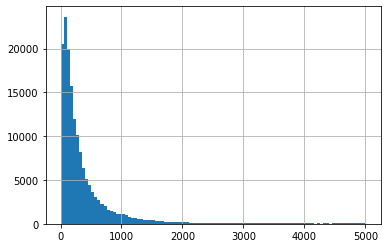

In [28]:
# distribution of text lengths
lens.hist(bins=100)

In [8]:
df_test_labels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,-1,-1,-1,-1,-1,-1
0000247867823ef7,-1,-1,-1,-1,-1,-1
00013b17ad220c46,-1,-1,-1,-1,-1,-1
00017563c3f7919a,-1,-1,-1,-1,-1,-1
00017695ad8997eb,-1,-1,-1,-1,-1,-1


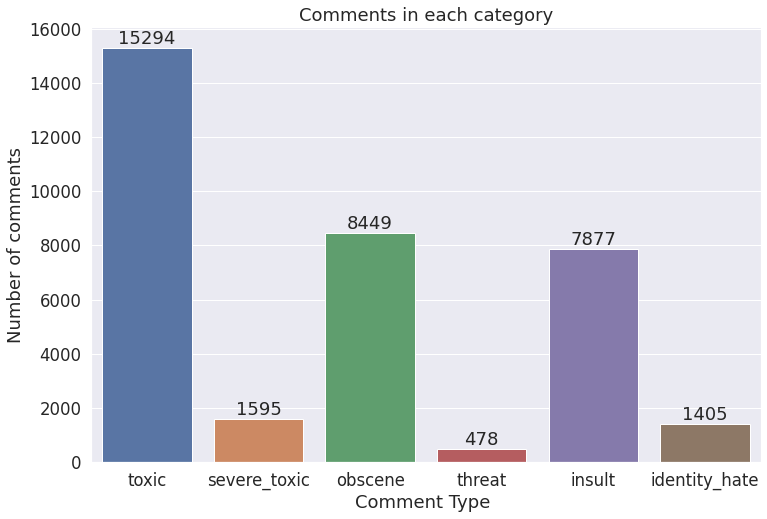

In [7]:
#Counting the number of comments under each label
sns.set(font_scale = 1.5)
categories = list(df_train.columns.values)
plt.figure(figsize=(12,8))
ax = sns.barplot(categories[2:], df_train.iloc[:,2:].sum().values)
plt.title("Comments in each category")
plt.ylabel('Number of comments')
plt.xlabel('Comment Type ')
#adding the text labels
rects = ax.patches
labels = df_train.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

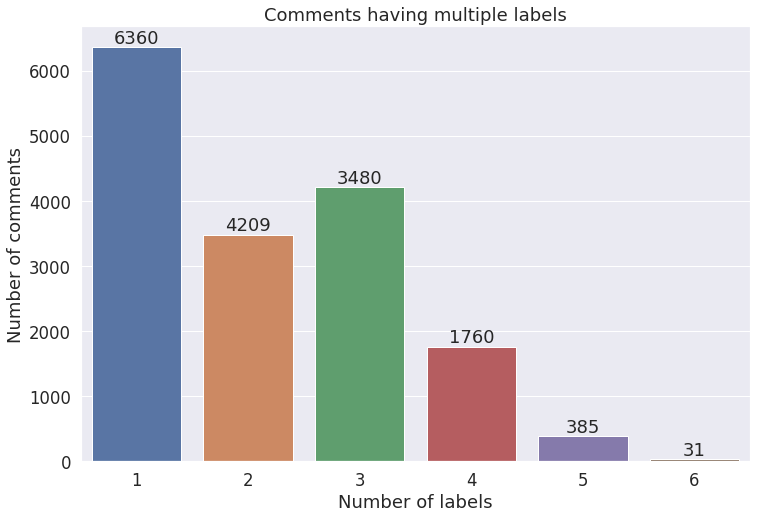

In [8]:
#Counting the number of comments having multiple labels
sns.set(font_scale = 1.5)
rowSums = df_train.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
plt.figure(figsize=(12,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Comments having multiple labels")
plt.ylabel('Number of comments')
plt.xlabel('Number of labels')
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

### Extract Toxic labels only

In [11]:
df_train_toxic = df_train.iloc[:,0:3]
df_train_toxic

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0


In [15]:
df_test_labels_toxic = df_test_labels.iloc[:,0:1]
df_test_labels_toxic.head()

,toxic
id,
00001cee341fdb12,-1
0000247867823ef7,-1
00013b17ad220c46,-1
00017563c3f7919a,-1
00017695ad8997eb,-1


In [22]:
df_train_toxic.groupby([('toxic')]).size()

toxic
0    144277
1     15294
dtype: int64

In [23]:
df_test_labels_toxic.groupby([('toxic')]).size()

toxic
-1    89186
 0    57888
 1     6090
dtype: int64

In [9]:
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences

bert_model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=True)
MAX_LEN = 128

def tokenize_sentences(sentences, tokenizer, max_seq_len = 128):
    tokenized_sentences = []

    for sentence in tqdm(sentences):
        tokenized_sentence = tokenizer.encode(
                            sentence,                  # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_seq_len,  # Truncate all sentences.
                    )
        
        tokenized_sentences.append(tokenized_sentence)

    return tokenized_sentences

def create_attention_masks(tokenized_and_padded_sentences):
    attention_masks = []

    for sentence in tokenized_and_padded_sentences:
        att_mask = [int(token_id > 0) for token_id in sentence]
        attention_masks.append(att_mask)

    return np.asarray(attention_masks)

input_ids = tokenize_sentences(df_train['comment_text'], tokenizer, MAX_LEN)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
attention_masks = create_attention_masks(input_ids)

  0%|          | 0/159571 [00:00<?, ?it/s]

In [10]:
from sklearn.model_selection import train_test_split

labels =  df_train[label_cols].values

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=0, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=0, test_size=0.1)

train_size = len(train_inputs)
validation_size = len(validation_inputs)

In [11]:
BATCH_SIZE = 32
NR_EPOCHS = 1

def create_dataset(data_tuple, epochs=1, batch_size=32, buffer_size=10000, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size)
    if train:
        dataset = dataset.prefetch(1)
    
    return dataset

train_dataset = create_dataset((train_inputs, train_masks, train_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)
validation_dataset = create_dataset((validation_inputs, validation_masks, validation_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)

## 2. BERT Model
- Load the pretrained BERT base-model from Transformers library
- Take the first hidden-state from BERT output (corresponding to CLS token) and feed it into a Dense layer with 6 neurons and sigmoid activation (Classifier). The outputs of this layer can be interpreted as probabilities for each of the 6 classes.

In [12]:
from transformers import TFBertModel
from tensorflow.keras.layers import Dense, Flatten

class BertClassifier(tf.keras.Model):    
    def __init__(self, bert: TFBertModel, num_classes: int):
        super().__init__()
        self.bert = bert
        self.classifier = Dense(num_classes, activation='sigmoid')
        
    @tf.function
    def call(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):
        outputs = self.bert(input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids,
                               position_ids=position_ids,
                               head_mask=head_mask)
        cls_output = outputs[1]
        cls_output = self.classifier(cls_output)
                
        return cls_output

model = BertClassifier(TFBertModel.from_pretrained(bert_model_name), len(label_cols))

## 3. Training Loop
- Use BinaryCrossentropy as loss function (is calculated for each of the output 6 output neurons ...that's like training 6 binary classification tasks at the same time) 
- Use the AdamW optimizer with 1-cycle-policy from the Transformers library
- AUC evaluation metrics

In [13]:
import time
from transformers import create_optimizer

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = validation_size // BATCH_SIZE

# | Loss Function
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)
train_loss = tf.keras.metrics.Mean(name='train_loss')
validation_loss = tf.keras.metrics.Mean(name='test_loss')

# | Optimizer (with 1-cycle-policy)
warmup_steps = steps_per_epoch // 3
total_steps = steps_per_epoch * NR_EPOCHS - warmup_steps
optimizer = create_optimizer(init_lr=2e-5, num_train_steps=total_steps, num_warmup_steps=warmup_steps)

# | Metrics
train_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]
validation_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]

@tf.function
def train_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(token_ids, attention_mask=masks)
        loss = loss_object(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables), 1.0)

    train_loss(loss)

    for i, auc in enumerate(train_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])
        
@tf.function
def validation_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    predictions = model(token_ids, attention_mask=masks, training=False)
    v_loss = loss_object(labels, predictions)

    validation_loss(v_loss)
    for i, auc in enumerate(validation_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])
                                              
def train(model, train_dataset, val_dataset, train_steps_per_epoch, val_steps_per_epoch, epochs):
    for epoch in range(epochs):
        print('=' * 50, f"EPOCH {epoch}", '=' * 50)

        start = time.time()

        for i, (token_ids, masks, labels) in enumerate(tqdm(train_dataset, total=train_steps_per_epoch)):
            train_step(model, token_ids, masks, labels)
            if i % 1000 == 0:
                print(f'\nTrain Step: {i}, Loss: {train_loss.result()}')
                for i, label_name in enumerate(label_cols):
                    print(f"{label_name} roc_auc {train_auc_metrics[i].result()}")
                    train_auc_metrics[i].reset_states()
        
        for i, (token_ids, masks, labels) in enumerate(tqdm(val_dataset, total=val_steps_per_epoch)):
            validation_step(model, token_ids, masks, labels)

        print(f'\nEpoch {epoch+1}, Validation Loss: {validation_loss.result()}, Time: {time.time()-start}\n')

        for i, label_name in enumerate(label_cols):
            print(f"{label_name} roc_auc {validation_auc_metrics[i].result()}")
            validation_auc_metrics[i].reset_states()

        print('\n')

        
train(model, train_dataset, validation_dataset, train_steps_per_epoch=steps_per_epoch, val_steps_per_epoch=validation_steps, epochs=NR_EPOCHS)

================================================== EPOCH 0 ==================================================


  0%|          | 0/4487 [00:00<?, ?it/s]


Train Step: 0, Loss: 0.9854928255081177
toxic roc_auc 0.6200000047683716
severe_toxic roc_auc 0.0
obscene roc_auc 0.5833333134651184
threat roc_auc 0.6290322542190552
insult roc_auc 0.6383929252624512
identity_hate roc_auc 0.0

Train Step: 1000, Loss: 0.18003587424755096
toxic roc_auc 0.8929967880249023
severe_toxic roc_auc 0.8463453054428101
obscene roc_auc 0.9138899445533752
threat roc_auc 0.7553657293319702
insult roc_auc 0.8977550268173218
identity_hate roc_auc 0.7417423129081726

Train Step: 2000, Loss: 0.11141783744096756
toxic roc_auc 0.9790562987327576
severe_toxic roc_auc 0.9899704456329346
obscene roc_auc 0.9894557595252991
threat roc_auc 0.9532719850540161
insult roc_auc 0.9832171201705933
identity_hate roc_auc 0.9711839556694031

Train Step: 3000, Loss: 0.08749837428331375
toxic roc_auc 0.9845903515815735
severe_toxic roc_auc 0.98723965883255
obscene roc_auc 0.9880400896072388
threat roc_auc 0.9744024276733398
insult roc_auc 0.984599769115448
identity_hate roc_auc 0.980363

KeyboardInterrupt: ignored

## 4. Run predictions on test-set & save submission

In [ ]:
test_input_ids = tokenize_sentences(df_test['comment_text'], tokenizer, MAX_LEN)
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
test_attention_masks = create_attention_masks(test_input_ids)

In [ ]:
TEST_BATCH_SIZE = 32
test_steps = len(df_test) // TEST_BATCH_SIZE

test_dataset = create_dataset((test_input_ids, test_attention_masks), batch_size=TEST_BATCH_SIZE, train=False, epochs=1)

df_submission = pd.read_csv(subm_path, index_col='id')

for i, (token_ids, masks) in enumerate(tqdm(test_dataset, total=test_steps)):
    sample_ids = df_test.iloc[i*TEST_BATCH_SIZE:(i+1)*TEST_BATCH_SIZE]['id']
    predictions = model(token_ids, attention_mask=masks).numpy()

    df_submission.loc[sample_ids, label_cols] = predictions

In [ ]:
df_submission.to_csv('submission.csv')

In [ ]:
df_submission